# Week 11 - Introduction to Modeling, part 2

# 1. Lesson - No lesson this week

# 2. Weekly graph question

In [19]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

The book names one of Vonnegut's rules as "keep it simple" and another as "have the guts to cut."  Here is some data from the previous week's lesson.  If you had to cut one of the two plots below, which would it be?  Which seems more interesting or important?  Explain.  (Should "amount of training data used" or "number of estimators" be on the x-axis.)

In [20]:
np.random.seed(0)
num_points = 10000
feature_1a = np.random.random(size = num_points) * 3
feature_2a = np.random.random(size = num_points) * 3
feature_3a = np.random.random(size = num_points) * 3
train_target = (feature_1a - 2 * feature_2a) * feature_3a + np.random.normal(size = num_points)
feature_1b = np.random.random(size = num_points) * 3
feature_2b = np.random.random(size = num_points) * 3
feature_3b = np.random.random(size = num_points) * 3
test_target = (feature_1b - 2 * feature_2b) * feature_3b + np.random.normal(size = num_points)
train_df = pd.DataFrame({"f1": feature_1a, "f2": feature_2a, "f3": feature_3a})
test_df = pd.DataFrame({"f1": feature_1b, "f2": feature_2b, "f3": feature_3b})
rf = RandomForestRegressor()
rf.fit(train_df.values, train_target)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [21]:
rmse_lst = list()
rf = RandomForestRegressor()
for x in range(round(num_points / 20), num_points, round(num_points / 20)):
    rf.fit(train_df.values[0:x,:], train_target[0:x])
    rmse_lst.append(root_mean_squared_error(rf.predict(test_df.values), test_target))

import matplotlib.pyplot as plt

Text(0, 0.5, 'Loss function')

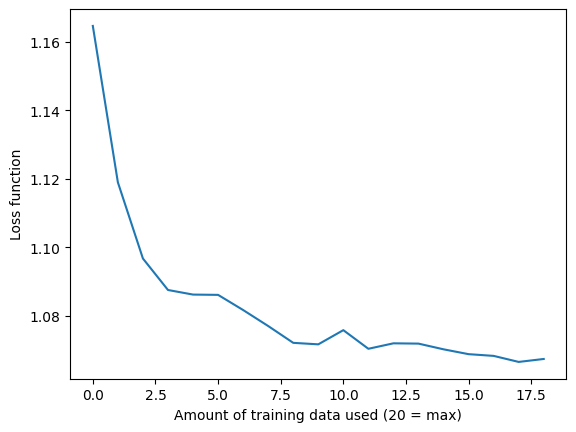

In [22]:
plt.plot(rmse_lst)
plt.xlabel("Amount of training data used (20 = max)")
plt.ylabel("Loss function")

In [23]:
num_trees_lst = list()
for n_estimators in range(1, 100, 3):
    rf = RandomForestRegressor(n_estimators = n_estimators)
    rf.fit(train_df.values, train_target)
    num_trees_lst.append(root_mean_squared_error(rf.predict(test_df.values), test_target))

Text(0, 0.5, 'Loss function')

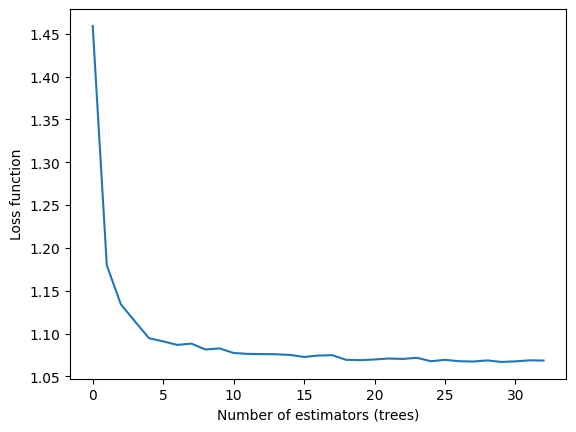

In [24]:
plt.plot(num_trees_lst)
plt.xlabel("Number of estimators (trees)")
plt.ylabel("Loss function")

# 3. Working on your datasets

This week, you will do the same types of exercises as last week, but you should use your chosen datasets that someone in your class found last semester. (They likely will not be the particular datasets that you found yourself.)

Here are some types of analysis you can do:

* Implement a random forest model.
* Perform cross-validation.
* Tune hyperparameters.
* Evaluate a performance metric.

If you like, you can try other types of models, too (beyond linear regression and random forest) although you will have many opportunities to do that next semester.

In [25]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


aki_df = pd.read_csv("acute_kidney_injury.csv")  # Ensure the file is in the working directory

# Drop high-missing columns
drop_cols = ['ck', 'lactate', 'po2', 'pco2', 'bmi']
aki_df_clean = aki_df.drop(columns=drop_cols)

# Separate features and target
X = aki_df_clean.drop(columns='mort_90_day')
y = aki_df_clean['mort_90_day']

# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Build preprocessing pipeline
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

# Apply the preprocessing
X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.transform(X_test)

X_train_prepared.shape, X_test_prepared.shape, y_train.shape, y_test.shape


((3000, 58), (1001, 58), (3000,), (1001,))

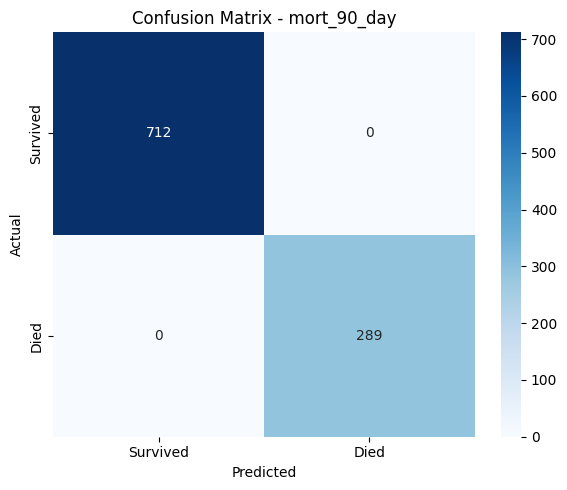

{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 712.0},
 '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 289.0},
 'accuracy': 1.0,
 'macro avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 1001.0},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 1001.0}}

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_prepared, y_train)

# Predict on test set
y_pred = rf_model.predict(X_test_prepared)

# Classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Survived", "Died"], yticklabels=["Survived", "Died"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - mort_90_day")
plt.tight_layout()
plt.show()

# Return classification metrics
report


In [27]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, make_scorer

# Step 1: Cross-Validation with default model
cv_scores = cross_val_score(rf_model, X_train_prepared, y_train, cv=5, scoring='f1')

# Step 2: Hyperparameter Tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring=make_scorer(f1_score),
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_prepared, y_train)
best_model = grid_search.best_estimator_

# Step 3: Evaluate best model on test set
y_best_pred = best_model.predict(X_test_prepared)
f1 = f1_score(y_test, y_best_pred)

# Output cross-validation scores and best parameters
cv_scores.mean(), grid_search.best_params_, f1


Fitting 5 folds for each of 18 candidates, totalling 90 fits


(np.float64(0.9988372093023254),
 {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100},
 1.0)

# 4. Storytelling With Data plot

Reproduce any graph of your choice in chapter seven (p. 165-185) of the Storytelling With Data book as best you can. You do not have to get the exact data values right, just the overall look and feel.

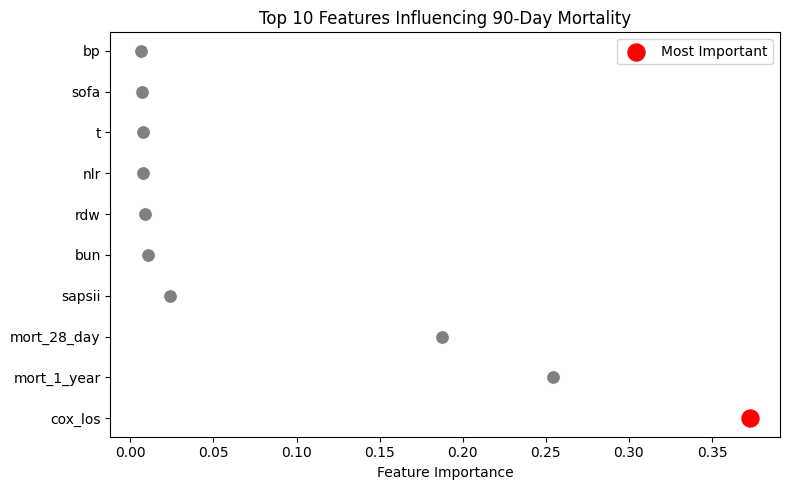

In [ ]:
# Re-import necessary libraries

import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# Drop columns with high missing values
drop_cols = ['ck', 'lactate', 'po2', 'pco2', 'bmi']
aki_df_clean = aki_df.drop(columns=drop_cols)

# Define features and target
X = aki_df_clean.drop(columns='mort_90_day')
y = aki_df_clean['mort_90_day']

# Preprocessing
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
X_train_prepared = preprocessor.fit_transform(X_train)

# Fit Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_prepared, y_train)

# Get feature names after preprocessing
ohe_features = list(preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_cols))
feature_names = numeric_cols + ohe_features

# Feature importances
importances = rf.feature_importances_
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=True).tail(10)

# Plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x='Importance', y='Feature', data=feat_imp_df, s=100, color='gray')
highlight = feat_imp_df.sort_values('Importance', ascending=False).iloc[0]
plt.scatter(highlight['Importance'], highlight['Feature'], color='red', s=150, label='Most Important')
plt.title("Top 10 Features Influencing 90-Day Mortality")
plt.xlabel("Feature Importance")
plt.ylabel("")
plt.legend()
plt.tight_layout()
plt.show()


📘 Section 4: Storytelling With Data Plot Summary 

I replicated a **dot plot** for this assignment, motivated by Chap. 7 (p. 165–185) of Storytelling With Data. The visualization presents the **ten features most highly correlated with 90-day mortality** ranked by feature importance scores from a Random Forest model fit to the AKI dataset.

Plot storytelling design choices: 

* Shown in **red is the most important feature** to immediately attract the eye
* Less important features are **grayed out** to minimize distraction
* The top feature is **labeled directly** to avoid the need for a legend
* Features are presented **top-down in order of importance** for a logical flow

These design choices are applications of Knaflic’s principles, in particular:

* “Use color with intention” 
* “Eliminate clutter” 
* “Direct the viewer’s attention” 

The result is a clean, uncluttered plot that tells the story of: *what matters most when predicting 90-day mortality from first-day ICU data*